In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

In [3]:
interest_rates = pd.read_csv('INTDSRUSM193N.csv')
unemployment_rates = pd.read_csv('UNRATE.csv')
volume_income = pd.read_csv('volume_data_Income_Level_AUT.csv')
volume_score = pd.read_csv('volume_data_Score_Level_AUT.csv')
yoy_income = pd.read_csv('yoy_data_Income_Level_AUT.csv')
yoy_score = pd.read_csv('yoy_data_Score_Level_AUT.csv')

In [4]:
interest_rates['observation_date'] = pd.to_datetime(interest_rates['observation_date'])
unemployment_rates['observation_date'] = pd.to_datetime(unemployment_rates['observation_date'])
volume_income['date'] = pd.to_datetime(volume_income['date'])
volume_score['date'] = pd.to_datetime(volume_score['date'])
yoy_income['date'] = pd.to_datetime(yoy_income['date'])
yoy_score['date'] = pd.to_datetime(yoy_score['date'])

In [5]:
common_start_date = max(
    interest_rates['observation_date'].min(),
    unemployment_rates['observation_date'].min(),
    volume_income['date'].min(),
    volume_score['date'].min(),
    yoy_income['date'].min(),
    yoy_score['date'].min()
)

common_end_date = min(
    interest_rates['observation_date'].max(),
    unemployment_rates['observation_date'].max(),
    volume_income['date'].max(),
    volume_score['date'].max(),
    yoy_income['date'].max(),
    yoy_score['date'].max()
)

In [6]:
interest_rates_filtered = interest_rates[(interest_rates['observation_date'] >= common_start_date) & 
                                         (interest_rates['observation_date'] <= common_end_date)]
unemployment_rates_filtered = unemployment_rates[(unemployment_rates['observation_date'] >= common_start_date) & 
                                                 (unemployment_rates['observation_date'] <= common_end_date)]
yoy_income_filtered = yoy_income[(yoy_income['date'] >= common_start_date) & 
                                 (yoy_income['date'] <= common_end_date)]

In [7]:
interest_rates_aligned = interest_rates_filtered.set_index('observation_date').resample('M').ffill().reset_index()
unemployment_rates_aligned = unemployment_rates_filtered.set_index('observation_date').resample('M').ffill().reset_index()
yoy_income_aligned = yoy_income_filtered.set_index('date').resample('M').ffill().reset_index()

/var/folders/nl/5yp3gpm55wbfd66ndpjsm9dm0000gn/T/ipykernel_74221/3790445307.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  interest_rates_aligned = interest_rates_filtered.set_index('observation_date').resample('M').ffill().reset_index()
/var/folders/nl/5yp3gpm55wbfd66ndpjsm9dm0000gn/T/ipykernel_74221/3790445307.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  unemployment_rates_aligned = unemployment_rates_filtered.set_index('observation_date').resample('M').ffill().reset_index()
/var/folders/nl/5yp3gpm55wbfd66ndpjsm9dm0000gn/T/ipykernel_74221/3790445307.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  yoy_income_aligned = yoy_income_filtered.set_index('date').resample('M').ffill().reset_index()


In [8]:
aligned_data = yoy_income_aligned.merge(
    interest_rates_aligned, left_on='date', right_on='observation_date'
).merge(
    unemployment_rates_aligned, left_on='date', right_on='observation_date'
).drop(columns=['observation_date_x', 'observation_date_y'])

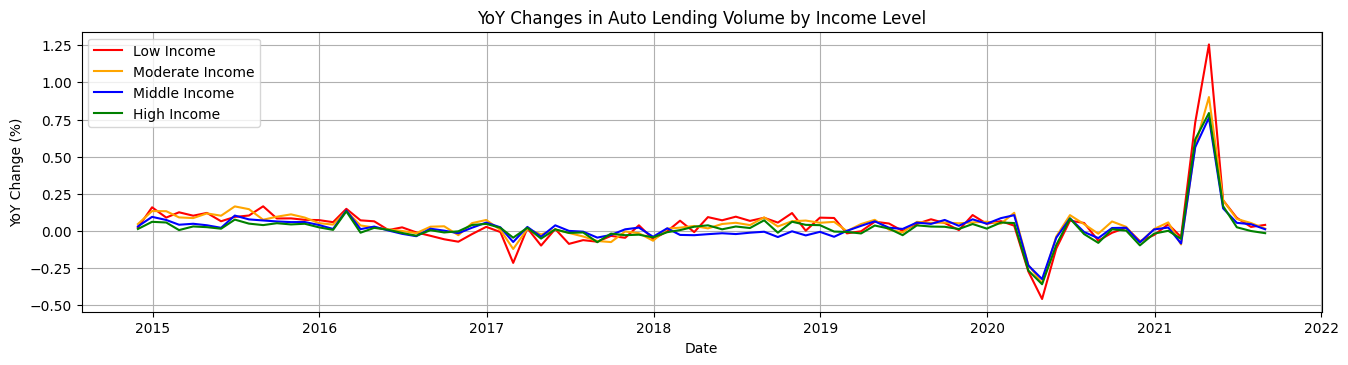

In [12]:
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
plt.plot(aligned_data['date'], aligned_data['low_yoy'], label='Low Income', color='red')
plt.plot(aligned_data['date'], aligned_data['moderate_yoy'], label='Moderate Income', color='orange')
plt.plot(aligned_data['date'], aligned_data['middle_yoy'], label='Middle Income', color='blue')
plt.plot(aligned_data['date'], aligned_data['high_yoy'], label='High Income', color='green')
plt.title('YoY Changes in Auto Lending Volume by Income Level')
plt.xlabel('Date')
plt.ylabel('YoY Change (%)')
plt.legend()
plt.grid(True)

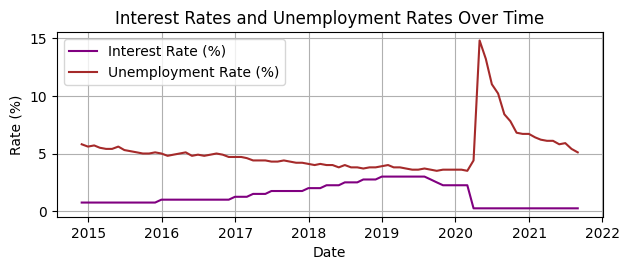

In [13]:
# Interest rates and unemployment rates
plt.subplot(2, 1, 2)
plt.plot(aligned_data['date'], aligned_data['INTDSRUSM193N'], label='Interest Rate (%)', color='purple')
plt.plot(aligned_data['date'], aligned_data['UNRATE'], label='Unemployment Rate (%)', color='brown')
plt.title('Interest Rates and Unemployment Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

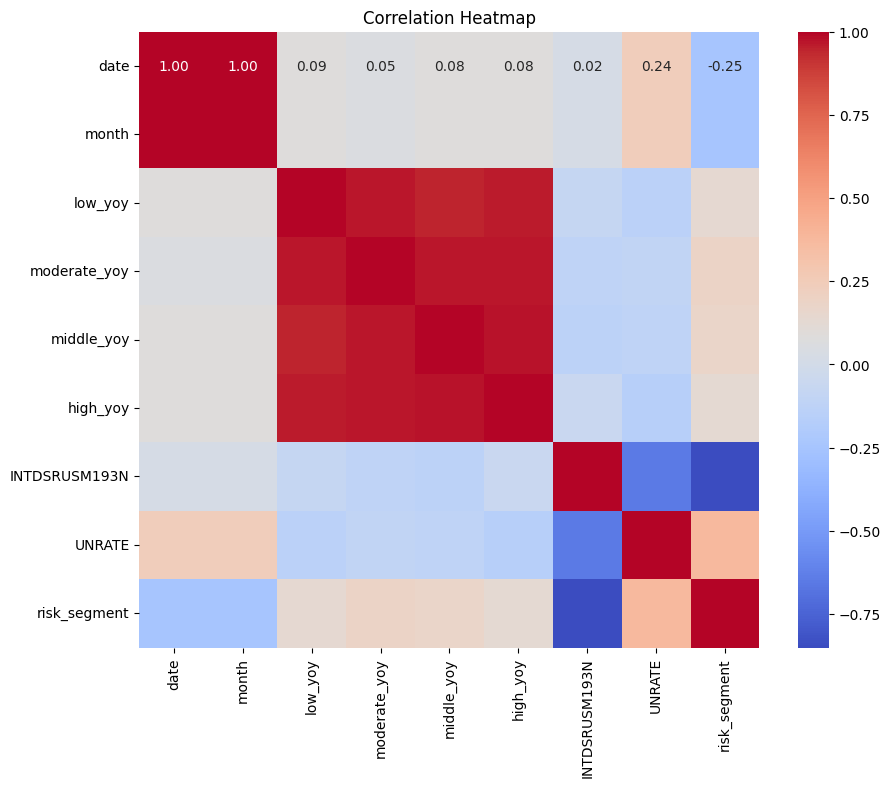

Correlation Matrix:
                   date     month   low_yoy  moderate_yoy  middle_yoy  \
date           1.000000  1.000000  0.085836      0.053947    0.084689   
month          1.000000  1.000000  0.085975      0.054070    0.084796   
low_yoy        0.085836  0.085975  1.000000      0.967207    0.943954   
moderate_yoy   0.053947  0.054070  0.967207      1.000000    0.965168   
middle_yoy     0.084689  0.084796  0.943954      0.965168    1.000000   
high_yoy       0.082935  0.083053  0.958808      0.967770    0.971728   
INTDSRUSM193N  0.021901  0.022068 -0.080190     -0.117970   -0.129339   
UNRATE         0.238968  0.238915 -0.134961     -0.101896   -0.115079   
risk_segment  -0.245639 -0.245809  0.139725      0.188845    0.173075   

               high_yoy  INTDSRUSM193N    UNRATE  risk_segment  
date           0.082935       0.021901  0.238968     -0.245639  
month          0.083053       0.022068  0.238915     -0.245809  
low_yoy        0.958808      -0.080190 -0.134961      

In [14]:
correlation_matrix = aligned_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

print("Correlation Matrix:")
print(correlation_matrix)

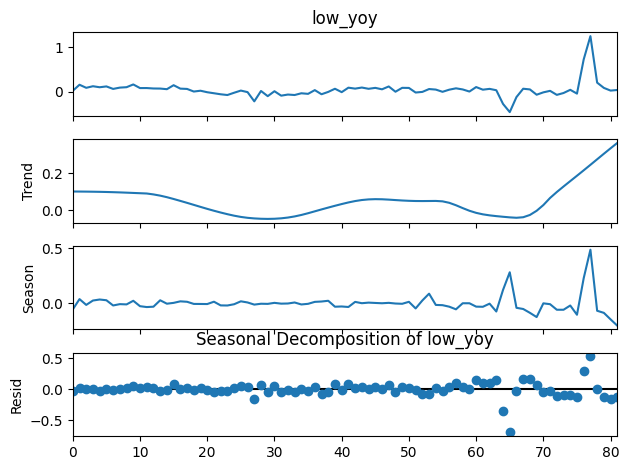

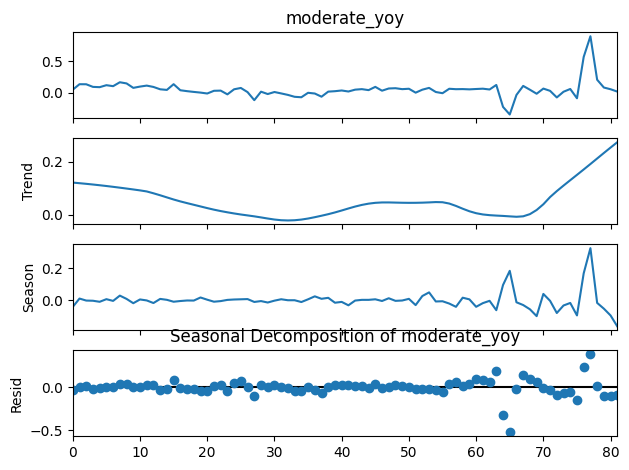

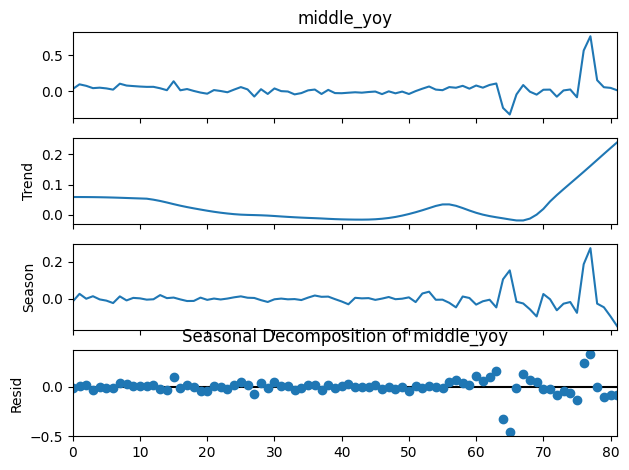

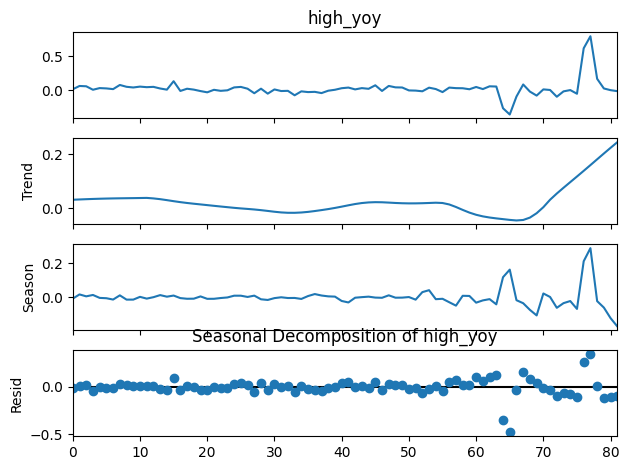

In [15]:
for col in ['low_yoy', 'moderate_yoy', 'middle_yoy', 'high_yoy']:
    stl = STL(aligned_data[col], period=12)
    result = stl.fit()
    result.plot()
    plt.title(f'Seasonal Decomposition of {col}')
    plt.show()

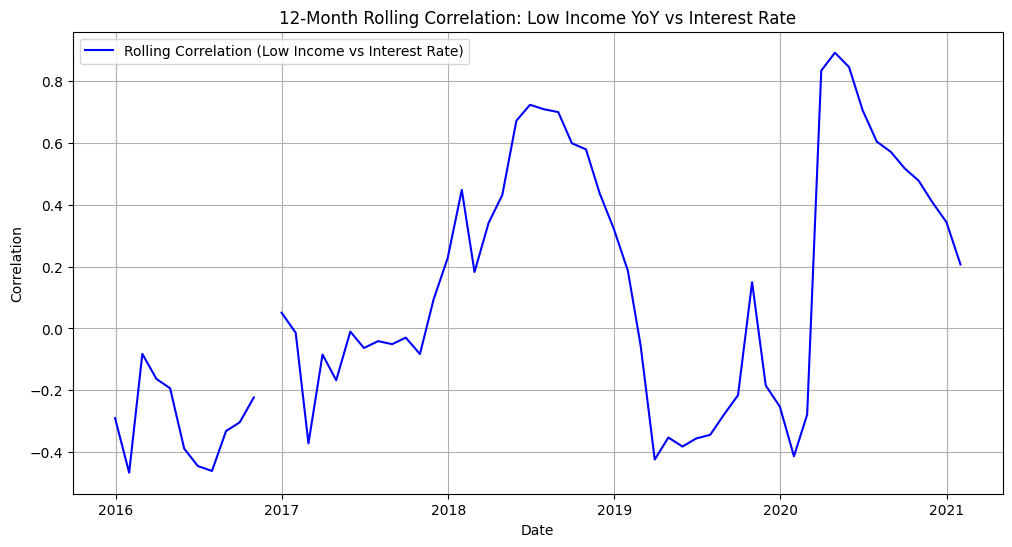

In [16]:
rolling_corr = aligned_data['low_yoy'].rolling(12).corr(aligned_data['INTDSRUSM193N'])
plt.figure(figsize=(12, 6))
plt.plot(aligned_data['date'], rolling_corr, label='Rolling Correlation (Low Income vs Interest Rate)', color='blue')
plt.title('12-Month Rolling Correlation: Low Income YoY vs Interest Rate')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
def calculate_credit_score(income_level, credit_score, interest_rate, unemployment_rate):
    econ_score = 1 / (interest_rate + unemployment_rate + 1e-6)
    total_score = (weights['income_level'] * income_level +
                   weights['credit_score'] * credit_score +
                   weights['economic_conditions'] * econ_score)
    return total_score

weights = {
    'income_level': 0.4,  
    'credit_score': 0.5,  
    'economic_conditions': 0.1  
}

In [19]:
example_score = calculate_credit_score(income_level=4, credit_score=5, interest_rate=2.5, unemployment_rate=5.0)
print(f"Example Credit Score: {example_score:.2f}")

Example Credit Score: 4.11


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


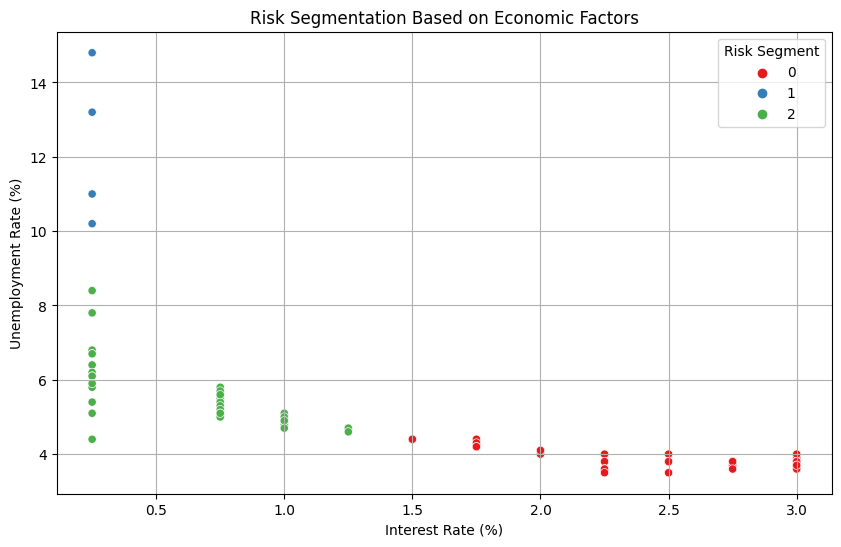

In [21]:
clustering_data = aligned_data[['low_yoy', 'moderate_yoy', 'middle_yoy', 'high_yoy', 'INTDSRUSM193N', 'UNRATE']]
kmeans = KMeans(n_clusters=3, random_state=42).fit(clustering_data)
aligned_data['risk_segment'] = kmeans.labels_

# Plot clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='INTDSRUSM193N', y='UNRATE', hue='risk_segment', data=aligned_data, palette='Set1')
plt.title('Risk Segmentation Based on Economic Factors')
plt.xlabel('Interest Rate (%)')
plt.ylabel('Unemployment Rate (%)')
plt.legend(title='Risk Segment')
plt.grid(True)
plt.show()


Gradient Boosting Accuracy: 0.68
Random Forest Accuracy: 0.72
Logistic Regression Accuracy: 0.88


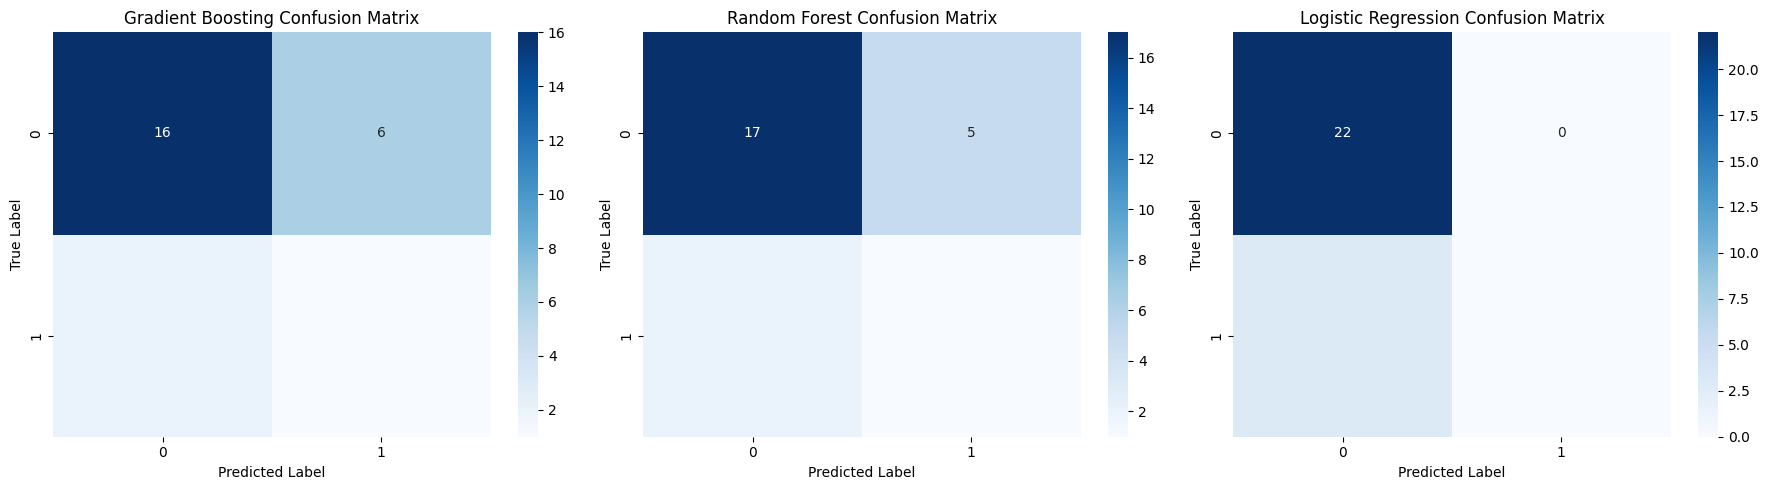

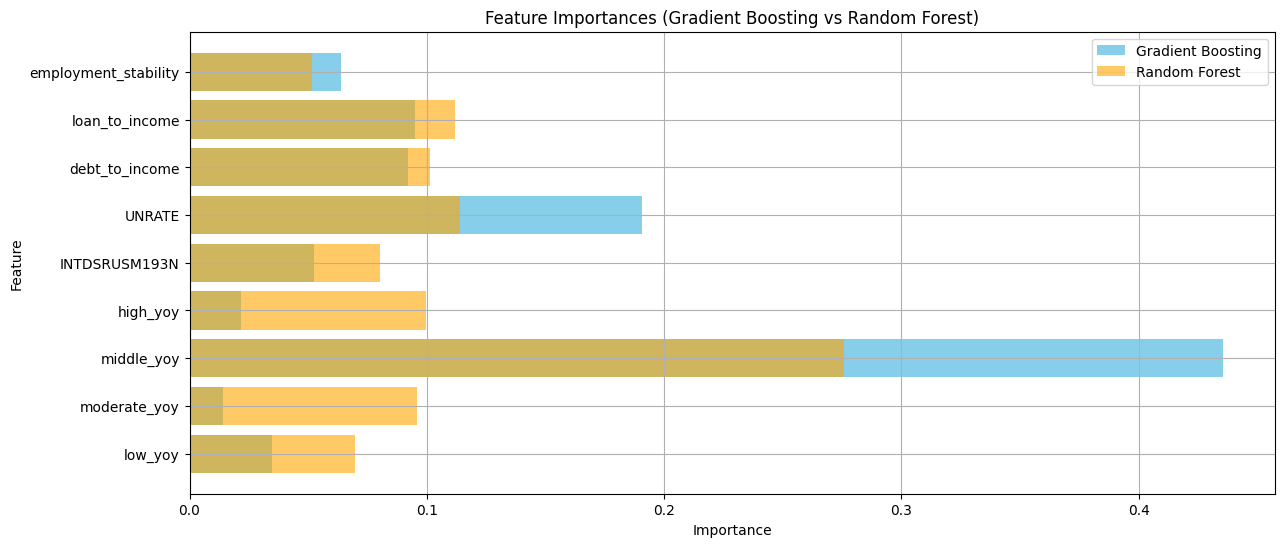

In [29]:
# Generate synthetic data for additional factors
np.random.seed(42)
aligned_data['debt_to_income'] = np.random.uniform(20, 50, len(aligned_data))  # Debt-to-income ratio
aligned_data['loan_to_income'] = np.random.uniform(0.1, 0.5, len(aligned_data))  # Loan amount relative to income
aligned_data['employment_stability'] = np.random.randint(1, 10, len(aligned_data))  # Employment stability (years)
aligned_data['delinquency'] = np.random.choice([0, 1], size=len(aligned_data), p=[0.8, 0.2])  # Synthetic target variable

# Prepare features and target for machine learning
features = ['low_yoy', 'moderate_yoy', 'middle_yoy', 'high_yoy', 'INTDSRUSM193N', 'UNRATE', 
            'debt_to_income', 'loan_to_income', 'employment_stability']
target = 'delinquency'

X = aligned_data[features]
y = aligned_data[target]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train and evaluate Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Gradient Boosting Accuracy: {accuracy_gb:.2f}")

# Train and evaluate Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

# Train and evaluate Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=500)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr:.2f}")

# Plot confusion matrices for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
models = {'Gradient Boosting': y_pred_gb, 'Random Forest': y_pred_rf, 'Logistic Regression': y_pred_lr}
for ax, (model_name, y_pred) in zip(axes, models.items()):
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{model_name} Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.tight_layout()
plt.show()

# Plot feature importance for Gradient Boosting and Random Forest
feature_importances_gb = gb_model.feature_importances_
feature_importances_rf = rf_model.feature_importances_

plt.figure(figsize=(14, 6))
plt.barh(features, feature_importances_gb, color='skyblue', label='Gradient Boosting')
plt.barh(features, feature_importances_rf, color='orange', alpha=0.6, label='Random Forest')
plt.title('Feature Importances (Gradient Boosting vs Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.legend()
plt.grid(True)
plt.show()
